# Debugging/Testing

Julia has straightforward methods for [testing your code](https://docs.julialang.org/en/v1/stdlib/Test/).

In [1]:
using Test

@test true
@test_throws "unimplemented" throw("unimplemented")

Test Passed
      Thrown: String

### TDD

One strategy for developing code with fewer bugs is [test-driven development (TDD)](https://courses.cs.cornell.edu/cs3110/2021sp/textbook/data/tdd.html).
The principle is to always have working code, and make it do more and more things correct. The workflow is 

1. Write a failing test.
2. Make the test pass.
3. Clean up the code.

Here's a quick demo. Let's play the game "FizzBuzz," which is to loop through the first 100 numbers, printing "Fizz" if the number is divisible by 3, "Buzz" if the number is divisible by 5, "FizzBuzz" if it is divisible by both, and just the number if neither.

In [12]:
"""
    fizz_buzz(n)

Creates the string output for a positive integer `n` according to the rules of FizzBuzz.

Throws an `ArgumentError` if `n` is 0 or negative.
"""
function fizz_buzz(n)
    if n ≤ 0 
        throw(ArgumentError(""))
    end
    if n % 3 == 0 && n % 5 == 0 
        return "FizzBuzz"
    end
    if n % 3 == 0 
        return "Fizz"
    end
    if n % 5 == 0 
        return "Buzz"
    end
    return string(n)
end

@test fizz_buzz(1) == "1"
@test fizz_buzz(3) == "Fizz"
@test fizz_buzz(5) == "Buzz"

@test_throws ArgumentError fizz_buzz(-1) 

@testset "multiples of 3" begin
    for i in [x for x in 3:3:100 if x % 5 ≠ 0 ]
        @test fizz_buzz(i) == "Fizz"
    end
end

@testset "multiples of 5" begin
    for i in [x for x in 5:5:100 if x % 3 ≠ 0]
        @test fizz_buzz(i) == "Buzz"
    end
end

@testset "multiples of 3 and 5" begin
    for i in [x for x in 5:5:100 if x % 3 == 0]
        @test fizz_buzz(i) == "FizzBuzz"
    end
end


Test Summary:  | Pass  Total  Time
multiples of 3 |   27     27  0.1s
Test Summary:  | Pass  Total  Time
multiples of 5 |   14     14  0.0s
Test Summary:        | Pass  Total  Time
multiples of 3 and 5 |    6      6  0.0s


Test.DefaultTestSet("multiples of 3 and 5", Any[], 6, false, false, true, 1.707345229699355e9, 1.707345229742367e9, false)

# Random Numbers

We will learn how to implement [rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling#Algorithm). The basic idea of the algorithm is to draw samples from a larger distribution, and then to accept or reject those samples in a way that generates your desired distribution. We will also explore the subtlety of defining random variables.

### Exercise 1
1. Create a function that draws $n$ random samples uniformly distributed inside the unit square.
2. Now, create a function that draws $n$ random samples uniformly distributed inside the unit circle, where uniform means that the distribution is the same as uniformly over the square, but you only care about the points in the circle.
3. Create a function that draws $n$ random samples uniformly distributed inside the unit circle, except this time, choose points by uniformly picking a radius and an angle.
4. Plot histograms of the radius for (2) and (3). What do you notice? Why do the histograms look this way? Which aligns with your intuition about what uniformly distributed should be?

In [5]:
function sample_square_once()
    x = 2 * rand() - 1
    y = 2 * rand() - 1
    return [x, y]
end

function sample_square_1(n)
    x = zeros(n)
    y = zeros(n)
    for i = 1:n
        xi, yi = sample_square_once()
        x[i] = xi
        y[i] = yi
    end
    return x, y
end   

function sample_square_2(n)
    return [sample_square_once() for _ in 1:n]
end

sample_square_2 (generic function with 1 method)

In [6]:
function sample_circle_once()
    while true
        x, y  = sample_square_once()
        if x^2 + y^2 ≤ 1
            return [x, y]
        end
    end
end

function sample_circle_2(n)
    return [sample_circle_once() for _ in 1:n]
end

function sample_circle_1(n)
    x = zeros(n)
    y = zeros(n)
    for i = 1:n
        xi, yi = sample_circle_once()
        x[i] = xi
        y[i] = yi
    end
    return x, y
end

sample_circle_1 (generic function with 1 method)

Instead of repeating a lot of code, we can abstract away the common parts so that we only write it once.

In [18]:
function sample_many(sampler, n)
    x = zeros(n)
    y = zeros(n)
    for i = 1:n
        xi, yi = sampler()
        x[i] = xi
        y[i] = yi
    end
    return x, y
end

sample_square_easy(n) = sample_many(sample_square_once, n)
sample_circle_easy(n) = sample_many(sample_circle_once, n)

sample_circle_easy (generic function with 1 method)

In [7]:
function sample_circle_weird(n)
    function convert(v)
        return [cos(v[2]), sin(v[2])] * v[1]
    end
    return convert.([[rand(), 2*pi*rand()] for _ in 1:n])
end

sample_circle_weird (generic function with 1 method)

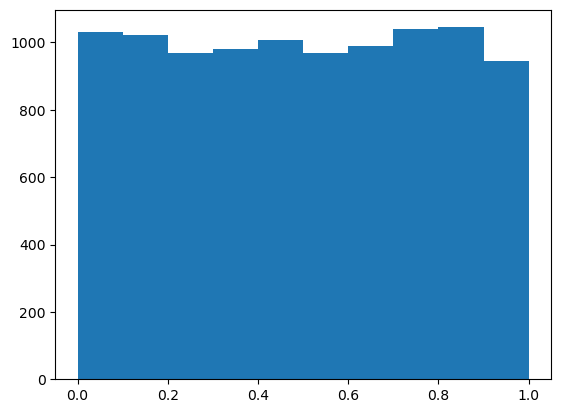

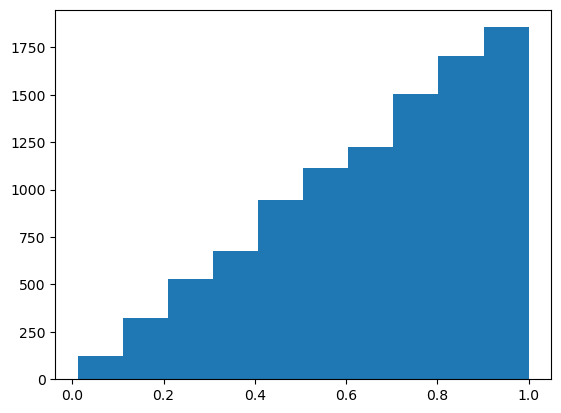

In [9]:
using LinearAlgebra
radius = norm
using PyPlot

weird_samples = sample_circle_weird(10000)
normal_samples = sample_circle_2(10000)

weird_r = radius.(weird_samples)
normal_r = radius.(normal_samples)

figure(1)
hist(weird_r, 10);

figure(2)
hist(normal_r, 10);

### Exercise 2

Suppose you want to draw from a distribution who's probability density is a downwards parabola over the interval $[-10,-6]$, i.e. $$p(x) = \frac{-(x+10)(x+6)}{Z}$$
where $Z$ is an appropriate normalizing constant.

1. Compute $Z$.
2. Implement rejection sampling, and verify that your distribution is correct by plotting the histogram for $1000$ samples.
3. Suppose you win $f(x) = |x|$ dollars for drawing $x$. About how many dollars would you pay to play one round of this game? Estimate using Monte-Carlo simulation.

### Challenge

Write a function that draws from the standard normal distribution using only `rand` for the randomness (i.e. without using `randn`). One good strategy is to use the central limit theorem (see [here](https://bjlkeng.io/posts/sampling-from-a-normal-distribution/)).